
# Chapter 10 - Deep Learning for Timeseries
  
We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.1 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016

In [32]:
# Let’s start by downloading and uncompressing the data:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip -P data/
!unzip data/jena_climate_2009_2016.csv.zip -d data/

--2024-06-30 21:31:57--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.229.120, 52.217.161.48, 52.217.105.166, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.229.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘data/jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  20.0MB/s    in 0.6s    

2024-06-30 21:31:58 (20.0 MB/s) - ‘data/jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  data/jena_climate_2009_2016.csv.zip
replace data/jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
# see data
import pandas as pd

data = pd.read_csv("data/jena_climate_2009_2016.csv")
data.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


In [2]:
# Now we will drop the date column and split the temperature into its own array (target)
temperatures = data["T (degC)"]
features = data.drop(columns=["Date Time"])
temperatures.shape

(420451,)

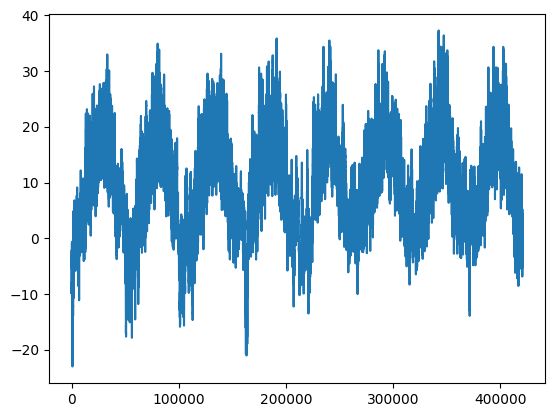

In [3]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperatures)), temperatures)

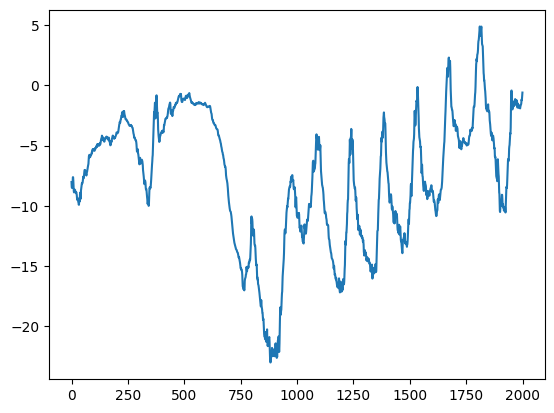

In [4]:
# plotting the first few points only
plt.plot(range(2000), temperatures[:2000])


**Periodicity over multiple timescales is an important and very common property of timeseries data.** 


**When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that**

In [5]:
# We’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing
total_data = len(data)
train_size = int(total_data * 0.50)
val_size = int(total_data * 0.25)
test_size = total_data - train_size - val_size
print(train_size, val_size, test_size)

210225 105112 105114


## Preparing Data
1. The data is already numerical, so you don’t need to do any vectorization
2. Columns are on different scales -> Normalize

In [6]:
# normalize only train data
mean = features[:train_size].mean(axis=0)
std = features[:train_size].std(axis=0)
features -= mean
features /= std
features.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.913649,-1.920636,-1.974488,-1.866254,1.048015,-1.291316,-1.467152,-0.782343,-1.470122,-1.472032,2.124151,-0.730165,-0.779351,-0.281192
1,0.919528,-1.965100,-2.018478,-1.919925,1.054028,-1.304472,-1.488855,-0.784440,-1.489114,-1.493462,2.172914,-0.932305,-0.886968,-0.469893
2,0.914825,-1.976501,-2.029758,-1.924162,1.084097,-1.307103,-1.491266,-0.786537,-1.492912,-1.495843,2.183381,-1.277899,-1.261473,-0.056383
3,0.912474,-1.953699,-2.006071,-1.890265,1.102138,-1.300525,-1.476798,-0.788633,-1.477719,-1.481556,2.158404,-1.180089,-1.317434,0.251128
4,0.912474,-1.949139,-2.002687,-1.886027,1.096124,-1.299210,-1.474386,-0.788633,-1.477719,-1.479175,2.153885,-1.193130,-1.261473,0.440993


### Info Session

Data normalization by subtracting the mean and dividing by the standard deviation, often called "standardization" or "Z-score normalization," is a common preprocessing step in machine learning and statistics. This process transforms the data to have a mean of 0 and a standard deviation of 1. Here's why this is beneficial:

**Centering the Data(subtracting mean):** When we subtract the mean from each data point, we shift the data distribution so that its center is now at zero. This is helpful because many machine learning algorithms assume that the data is centered around zero, improving numerical stability and convergence during training.

**Scaling the Data (dividing by STD):** By dividing by the standard deviation, we scale the data so that it has a standard deviation of 1. This step ensures that different features contribute equally to the distance metrics used in many algorithms (like k-means clustering, nearest neighbors, or gradient-based optimization algorithms).

**We'll use timeseries_dataset_from_array to read data.**

The general idea is that you provide an array of timeseries data (the data argument), and timeseries_dataset_from_array() gives you windows extracted from the original timeseries (we’ll call them “sequences”).

You can also pass a targets argument (an array) to timeseries_dataset_ from_array(). The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. So if you’re doing timeseries forecasting, targets should be the same array as data, offset by some amount.

In [9]:
import numpy as np
from tensorflow import keras

# Example
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],  # The target for the sequence that starts at data[N] will be data[N + 3].
    sequence_length=3,  # The sequences will be 3 steps long.
    batch_size=2,
)

for inputs, target in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(target[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2024-07-07 19:57:16.243668: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-07 19:57:16.243761: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-07 19:57:16.243775: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-07 19:57:16.243833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-07 19:57:16.243901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-07 19:57:16.449575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
sampling_rate = 6
# Observations will go back 5 days (120 hours).
sequence_length = 120
# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-delay],  # the last set of features 
    targets=temperatures[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_size)

val_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-delay],
    targets=temperatures[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_size,
    end_index=train_size + val_size)

test_dataset = keras.utils.timeseries_dataset_from_array(
    features[:-delay],
    targets=temperatures[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_size + val_size)

# Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close. 

### A common-sense, non-machine learning baseline
The author talks about how we should guess what the machine will predict.
Here in our case, it's a common since to predict that tomorrow's temperature is similar to today's.
 

In [9]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the input sequence.
        # We multiply by std and add mean to restore original value
        preds = samples[:, -1, 1] * std.iloc[1] + mean.iloc[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]

    return total_abs_err / samples_seen


print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2024-07-03 20:32:25.720068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44
Test MAE: 2.62


2024-07-03 20:32:27.602214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Let’s try a basic machine learning model
Usually we should try some Densely connected layer first before tring complicated things like RNNs.


In [22]:
inputs = keras.Input(shape=(sequence_length, len(features.iloc[0])))
x = keras.layers.Dense(16, activation="relu")(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 123.7344 - mae: 9.0648 - val_loss: 67.2987 - val_mae: 6.7432
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 76.7265 - mae: 7.1008 - val_loss: 65.8990 - val_mae: 6.6808
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 76.2683 - mae: 7.0797 - val_loss: 65.6939 - val_mae: 6.6715
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 76.2636 - mae: 7.0802 - val_loss: 65.6775 - val_mae: 6.6710
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 76.1497 - mae: 7.0754 - val_loss: 65.4454 - val_mae: 6.6594
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 76.1156 - mae: 7.0732 - val_loss: 65.8359 - val_mae: 6.6789
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 76.1187 - mae: 7.0737 - val_loss: 65.7056 - val_mae: 6.6726
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 76.1008 - mae: 7.0726 - val_loss: 65.4684 - val_mae: 6.6607
Epoch 9/10
819/819 ━━━━

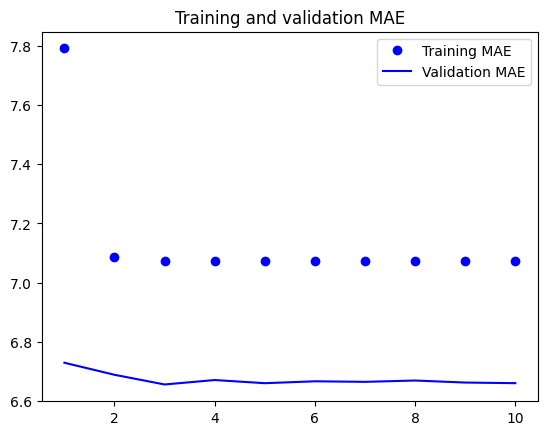

In [11]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Let’s try a 1D convolutional model
1D convolution can be best imagined as applying a sliding window of projections over a sequence of vectors. Kernel size is the window width, stride is the size of the step the window makes.

Why trying Conv1D?
- layers apply filters (kernels) of a specified length across the input sequence. This allows the model to capture local patterns or features within the sequence.
- Filters are applied across the entire length of the sequence, promoting parameter sharing and reducing the number of trainable parameters compared to fully connected layers.
- handle variable-length sequences
- Multiple Conv1D layers with pooling operations (like MaxPooling1D or AveragePooling1D) can learn hierarchical representations of the input sequence. Lower layers might capture low-level features (e.g., short patterns), while higher layers capture more abstract features (e.g., longer-term dependencies).

In [12]:
# We’ll pick an initial window length (kernel_size) of 24, and 8 filters, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via MaxPooling1D layers)
inputs = keras.Input(shape=(sequence_length, len(features.iloc[0])))
x = keras.layers.Conv1D(filters=8, kernel_size=24, activation="relu")(inputs)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Conv1D(filters=8, kernel_size=12, activation="relu")(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Conv1D(filters=8, kernel_size=6, activation="relu")(x)
# This is often used as an alternative to Flatten followed by Dense layers in CNNs for sequence data
x = keras.layers.GlobalAveragePooling1D()(x)
output = keras.layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=output)

callbacks = keras.callbacks.ModelCheckpoint("models/jena_conv.keras", save_best_only=True)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 34.8009 - mae: 4.4390 - val_loss: 14.6008 - val_mae: 3.0115
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 15.1451 - mae: 3.0950 - val_loss: 16.5053 - val_mae: 3.2196
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 13.8520 - mae: 2.9515 - val_loss: 16.2097 - val_mae: 3.1690
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 13.1192 - mae: 2.8679 - val_loss: 14.1615 - val_mae: 2.9613
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 12.4995 - mae: 2.7931 - val_loss: 14.3848 - val_mae: 2.9921
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 11.9886 - mae: 2.7326 - val_loss: 14.8264 - val_mae: 3.0288
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 11.5931 - mae: 2.6858 - val_loss: 14.8252 - val_mae: 3.0247
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 11.3110 - mae: 2.6530 - val_loss: 15.3188 - val_mae: 3.0599
Epoch 9/10
819/819 ━━━━━

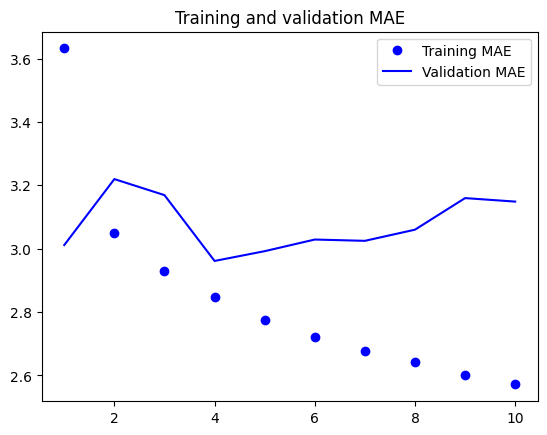

In [14]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Why does the convolutional model fail?
First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.

Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information. 

## A first recurrent baseline
Neither the fully connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem.

**Long Short Term Memory (LSTM)** layer is the solution.

In [15]:
inputs = keras.Input(shape=(sequence_length, len(features.iloc[0])))
x = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = keras.callbacks.ModelCheckpoint("models/jena_lstm.keras", save_best_only=True)
model.compile(optimizer="rmsprop", metrics=["mae"], loss="mse")
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - loss: 73.3027 - mae: 6.5614 - val_loss: 12.6423 - val_mae: 2.6874
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 11.8743 - mae: 2.6574 - val_loss: 9.5105 - val_mae: 2.3911
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 9.6191 - mae: 2.4139 - val_loss: 9.6504 - val_mae: 2.4049
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 9.0806 - mae: 2.3417 - val_loss: 9.8549 - val_mae: 2.4269
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 8.7373 - mae: 2.3003 - val_loss: 10.0759 - val_mae: 2.4439
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.4168 - mae: 2.2589 - val_loss: 10.2680 - val_mae: 2.4768
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.1828 - mae: 2.2289 - val_loss: 10.8079 - val_mae: 2.5239
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 7.9788 - mae: 2.2067 - val_loss: 11.0497 - val_mae: 2.5645
Epoch 9/10
819/819 ━━━━━━━━━━━━━━

ValueError: File not found: filepath=jena_lstm.keras. Please ensure the file is an accessible `.keras` zip file.

In [16]:
model = keras.models.load_model("models/jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 10.8934 - mae: 2.5870
Test MAE: 2.59


In [1]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

NameError: name 'history' is not defined

## Understanding recurrent neural networks
Densely connected networks and convnets have no memory. Each input shown to them is processed independently, with no state kept between inputs.
With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. This is called **feedforward networks**.

Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.

**A recurrent neural network (RNN)** adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a state that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop.

![alt text](static/RNNs.png "RNNs")

The state of the RNN is reset between processing two different, independent sequences (such as two samples in a batch). This data point is no longer processed in a single step; rather, the network internally loops over sequence elements



We'll implement a toy RNN layer. The input of the layer is two things, state and data input.
The **state** is the output of the precious step.
The first step doesn't have a previous step hence no state.

Pseudocode of an RNN layer.
```
state_t = 0                         # initial state
for input_t in input_sequence:      # loop
    output_t = f(input_t, state_t)  #  the current step will take the state and the data as its input. f is a certain function.
    state_t = output_t              # output of the current step will be input of the next step
``` 

f is a function take two inputs, then applies an activation and a bias.

```
output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
```
W: weights for the input
U: weights for the state
b: bias

In [23]:
# Forward Pass of a simple RNN
import numpy as np

timesteps = 100  # Time-steps in the input sequence
input_features = 32  # Features in the input
output_features = 64  # Features in the output
inputs = np.random.random((timesteps, input_features))  # Generate Fake input Data
state_t = np.zeros((output_features,))  # Initialize state data with zero for the first step
W = np.random.random((output_features, input_features))  # Initialize input weights
U = np.random.random((output_features, output_features))  # Initialize step weights
b = np.random.random((output_features,))  # Initialize bias
successive_outputs = []
for input_t in inputs:  # loop over input data
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)  # using tanh activation with input, state, and bias
    successive_outputs.append(output_t)  # store output of each layer to an array
    state_t = output_t  # store the output to a state to use with the next input
final_output_sequence = np.stack(successive_outputs,
                                 axis=0)  # The final output is a rank-2 tensor of shape (time-steps, output_features).

Each timestep t in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past.
In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more.
Here is an unrolled version of RNN
![alt text](static/RNN_unrolled.png "RNNs Unrolled")


### A recurrent layer in Keras
In Keras, SimpleRNN processes batches of sequences. So its input shape will be `(batch_size, timesteps, input_features)`
Note that you can set the `timesteps` entry to `None`, which enables your network to process sequences of arbitrary length.

All recurrent layers in Keras (SimpleRNN, LSTM, and GRU) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape (batch_size, timesteps, output_features)) or return only the last output for each input sequence (a rank-2 tensor of shape (batch_ size, output_features)). These two modes are controlled by the `return_sequences` constructor argument.

Example Scenarios:
- Text Generation: Use return_sequences=True to generate a sequence of words or characters.
- Named Entity Recognition: Use return_sequences=True to tag each word in a sentence.
- Time Series Forecasting: Use return_sequences=True to predict values for each timestep in the future.
- Sentiment Analysis: Use return_sequences=False to classify the sentiment of an entire review.

Simple RNNs suffer from vanishing gradients.

## Long Short Term Memory
**LSTM** is an alternative of the simpler version RNNs. It adds a way to carry information across many timesteps.
LSTM saves information for later, thus preventing older signals from gradually vanishing during processing.

![alt text](static/LSTM.png "LSTM")

 The carry information will be combined with the input connection and the recurrent connection (via a dense transformation: a dot product with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep (via an activation function and a multiplication operation).
 
**Just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.** 


## 10.4 Advanced use of recurrent neural networks
We'll Learn:
- Recurrent dropout—This is a variant of dropout, used to fight overfitting in recurrent layers.
- Stacking recurrent layers—This increases the representational power of the model (at the cost of higher computational loads).
- Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.


## How to use Dropout with RNNs?
The same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. Also, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time.


Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units


In [21]:
inputs = keras.Input(batch_shape=(batch_size, 120, 14))
# without dropout, this network would have started overfitting right away
x = keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs)  # Using 32 units to be more expressive
x = keras.layers.Dropout(0.5)(x)  # To regularize the Dense layer, we also add a Dropout layer after the LSTM. The dropout layer after LSTM applies dropout to the output of the LSTM units, affecting the horizontal connections in the network, which is another layer of regularization.
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,  # Training for 50 epochs because dropout makes the convergence take more time.
                    validation_data=val_dataset,
                    batch_size=batch_size,
                    callbacks=callbacks)   

Epoch 1/50


ValueError: Exception encountered when calling LSTM.call().

[1mCannot unroll a RNN if the time dimension is undefined. 
- If using a Sequential model, specify the time dimension by passing an `Input()` as your first layer.
- If using the functional API, specify the time dimension by passing a `shape` or `batch_shape` argument to your `Input()`.[0m

Arguments received by LSTM.call():
  • sequences=tf.Tensor(shape=(None, None, 14), dtype=float32)
  • initial_state=None
  • mask=None
  • training=True

In [15]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

NameError: name 'history' is not defined

### Stacking Recurrent Layers
Recurrent layer stacking is a classic way to build more-powerful recurrent networks.
To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs. This is done by specifying `return_sequences=True.`

Next we will use Gated Recurrent Unit layers (GRU). GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture


In [ ]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, len(features.iloc[0])))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("models/jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

## Using bidirectional RNNs

A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It’s frequently used in natural language processing—**you could call it the Swiss Army knife of deep learning for natural language processing**.
RNNs are notably order-dependent: they process the timesteps of their input sequences in order. Bidirectional RNNs use two regular RNNs, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, **a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN**

In [24]:
# To instantiate a bidirectional RNN in Keras, you use the Bidirectional layer, which takes as its first argument a recurrent layer instance.
inputs = keras.Input(shape=(sequence_length, len(features.iloc[0])))
x = keras.layers.Bidirectional(keras.layers.LSTM(16))(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 

## Final Remarks
How to improve the current solution?
- Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.
- Adjust the learning rate used by the RMSprop optimizer, or try a different optimizer.
- Try using a stack of Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.
- Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.

Try simple models before expensive ones, to make sure the additional expense is justified. Sometimes a simple model will turn out to be your best option.

